In [29]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score

market_data = yf.download('SPY', start='2017-01-01', end='2021-10-21')

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Prices ($)')

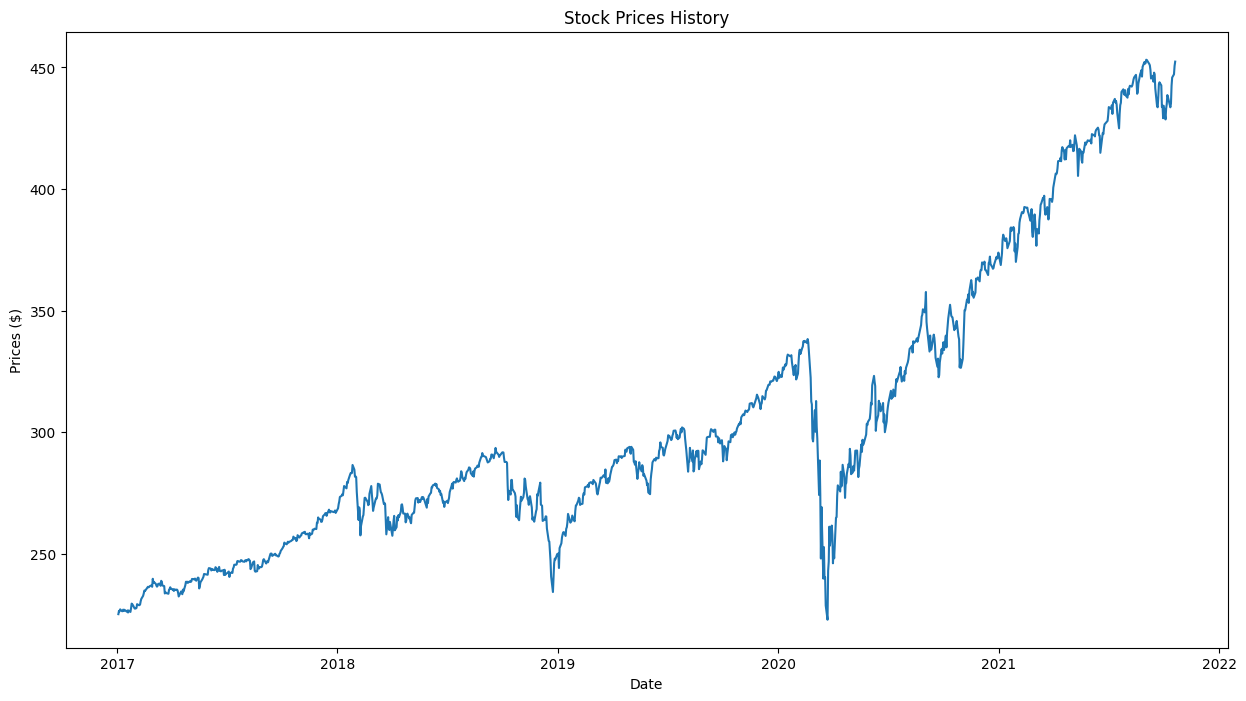

In [11]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(market_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [13]:
close_prices = market_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.75)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
847/847 [==============================] - 19s 18ms/step - loss: 0.0015
Epoch 2/3
847/847 [==============================] - 17s 20ms/step - loss: 7.1788e-04
Epoch 3/3
847/847 [==============================] - 18s 21ms/step - loss: 4.7084e-04


In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


10/10 [==============================] - 0s 16ms/step


C:\Users\gerar\AppData\Local\Temp\ipykernel_6656\3164585607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


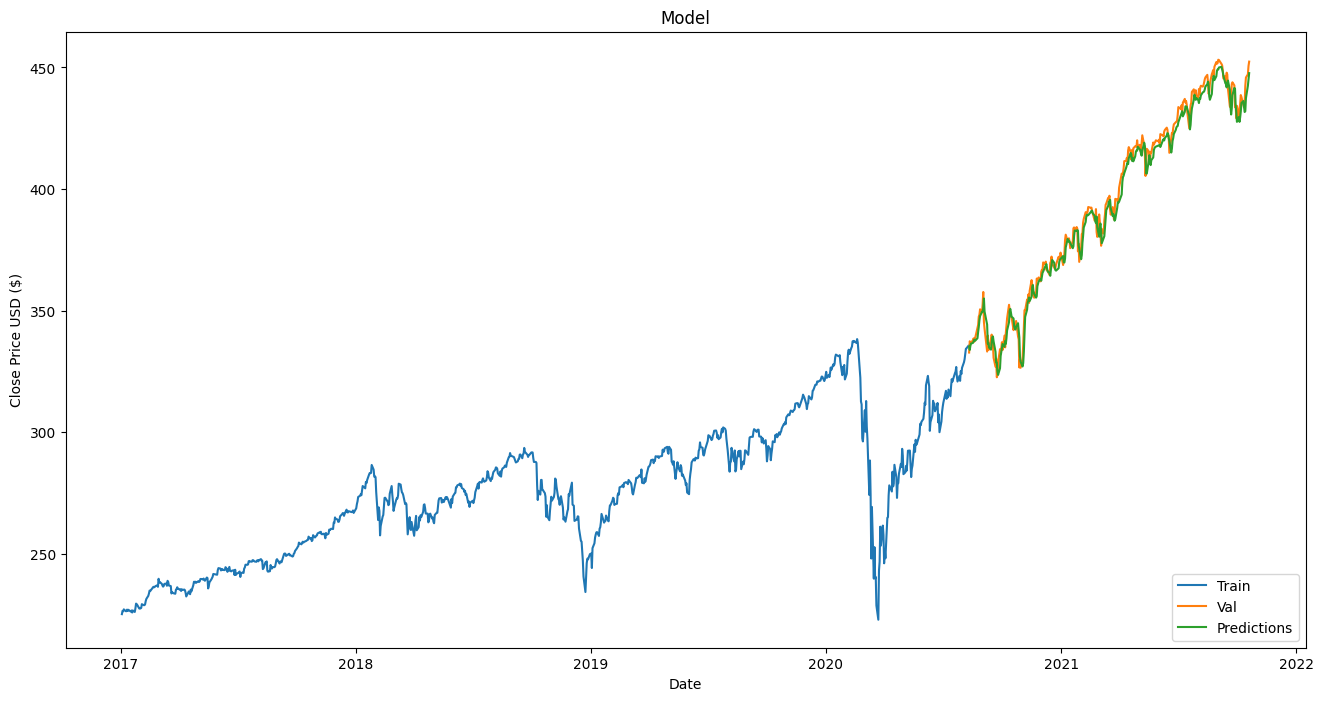

In [23]:
data = market_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Text(0, 0.5, 'Prices ($)')

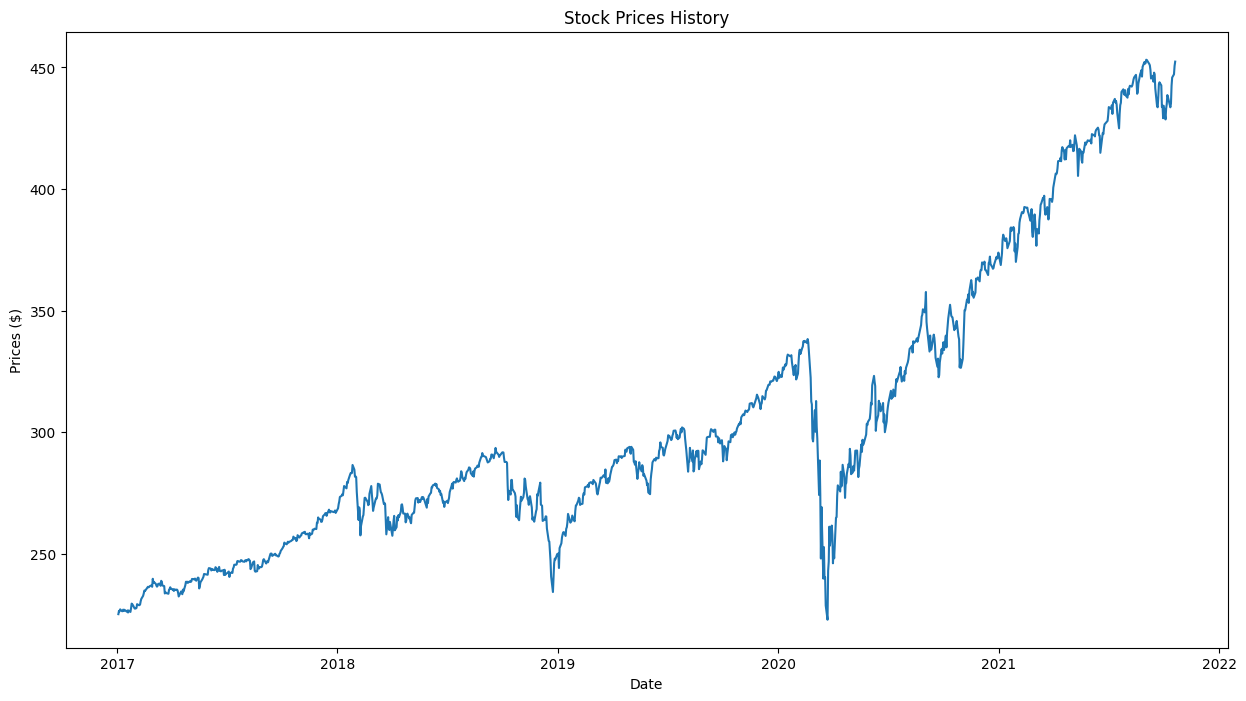

In [28]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(market_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [27]:
# Compute the metrics for the linear regression model
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f"The root mean squared error is {rmse}.")

The root mean squared error is 1.8790528758472165.
